In [1]:
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import wfdb
from tqdm.auto import tqdm

In [2]:
sns.set_context("notebook")
sns.set_style("whitegrid")

In [3]:
with open('./data/mit-bih-arrhythmia-database-1.0.0/RECORDS', "r") as f:
    records = f.read().split("\n")

In [4]:
ansi_map = {
    ".": "N",
    "N": "N",
    "L": "N",
    "R": "N",
    "e": "N",
    "j": "N",
    "A": "S",
    "J": "S",
    "a": "S",
    "S": "S",
    "E": "V",
    "V": "V",
    "F": "F",
    "/": "Q",
    "f": "Q",
    "Q": "Q"
}

In [5]:
heartbeat_data = [] # list of lists (by record) of heartbeats
heartbeat_labels = [] # list of lists (by record) of labels
for record_id in tqdm(records):
    record = wfdb.rdrecord('./data/mit-bih-arrhythmia-database-1.0.0/' + record_id)
    annotation = wfdb.rdann('./data/mit-bih-arrhythmia-database-1.0.0/' + record_id, 'atr')
    heartbeats = []
    labels = []
    for (idx, hb_class) in zip(annotation.sample, annotation.symbol):
        # Get +- 180 samples around the heartbeat
        if hb_class not in ansi_map:
            continue
        try:
            heartbeat = record.p_signal[idx - 180:idx + 180, 0] # only use first channel
        except Exception:
            continue
        if len(heartbeat) != 360:
            continue
        heartbeats.append(heartbeat)
        labels.append(ansi_map[hb_class])
    heartbeat_data.append(heartbeats)
    heartbeat_labels.append(labels)

  0%|          | 0/48 [00:00<?, ?it/s]

In [28]:
for (record_id, heartbeats, labels) in zip(records, heartbeat_data, heartbeat_labels):
    np.savez_compressed('./data/heartbeats/' + record_id, heartbeats=heartbeats, labels=labels)

In [9]:
npzfile = np.load('./data/heartbeats/100.npz')
print(npzfile.files)

['heartbeats', 'labels']


In [10]:
npzfile["heartbeats"].shape

(2271, 360)

In [6]:
# find the most average record by proportion of labels
# (i.e. the record with the closest distribution of labels to the average)

heartbeat_labels = {}
for _, _, files in os.walk("./data/heartbeats/"):
    for file in tqdm(files):
        npzfile = np.load('./data/heartbeats/' + file)
        heartbeat_labels[file] = npzfile["labels"]

label_counts = {}
for record_id in tqdm(heartbeat_labels):
    for label in heartbeat_labels[record_id]:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

label_counts

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

{'N': 90582, 'S': 2781, 'V': 7235, 'Q': 8038, 'F': 802}

In [7]:
for label, count in label_counts.items():
    print(f"{label}: {count / sum(label_counts.values()):.2f}")

N: 0.83
S: 0.03
V: 0.07
Q: 0.07
F: 0.01


In [8]:
label_proportions = {label: count / sum(label_counts.values()) for label, count in label_counts.items()}

In [6]:
def weighted_distance_from_ratio(ratio, label_counts):
    # ratio: target dict of label to proportion
    # label_counts: dict of label in record to count
    distance = 0
    length = sum(label_counts.values())
    label_ratios = {label: 0 for label in ratio.keys()}
    label_ratios = {label: count / length for label, count in label_counts.items()}
    for (label, prop) in ratio.items():
        distance += abs(ratio[label] - label_ratios[label]) * prop
    return distance

In [11]:
len(heartbeat_labels["100.npz"])

2271

In [12]:
len(np.argwhere(heartbeat_labels["100.npz"] == "Q"))

0

In [18]:
distances = {}
for record_id in tqdm(heartbeat_labels):
    record_counts = {label: len(np.argwhere(heartbeat_labels[record_id] == label)) for label in label_counts.keys()}
    distance = weighted_distance_from_ratio(label_proportions, record_counts)
    print(f"{record_id}: {distance:.2f}")
    distances[record_id] = distance

# sort by distance
sorted(distances.items(), key=lambda x: x[1])

  0%|          | 0/48 [00:00<?, ?it/s]

100.npz: 0.14
101.npz: 0.15
102.npz: 0.72
103.npz: 0.15
104.npz: 0.69
105.npz: 0.14
106.npz: 0.09
107.npz: 0.75
108.npz: 0.14
109.npz: 0.14
111.npz: 0.15
112.npz: 0.15
113.npz: 0.15
114.npz: 0.13
115.npz: 0.15
116.npz: 0.11
117.npz: 0.15
118.npz: 0.11
119.npz: 0.06
121.npz: 0.15
122.npz: 0.15
123.npz: 0.15
124.npz: 0.11
200.npz: 0.15
201.npz: 0.01
202.npz: 0.12
203.npz: 0.03
205.npz: 0.12
207.npz: 0.01
208.npz: 0.27
209.npz: 0.05
210.npz: 0.08
212.npz: 0.15
213.npz: 0.02
214.npz: 0.06
215.npz: 0.11
217.npz: 0.65
219.npz: 0.12
220.npz: 0.11
221.npz: 0.02
222.npz: 0.08
223.npz: 0.05
228.npz: 0.02
230.npz: 0.15
231.npz: 0.15
232.npz: 0.53
233.npz: 0.10
234.npz: 0.14


[('207.npz', 0.010833268033605542),
 ('201.npz', 0.012993623019520626),
 ('228.npz', 0.01796498452300128),
 ('213.npz', 0.019479441519031762),
 ('221.npz', 0.020070627561252528),
 ('203.npz', 0.02876206925701876),
 ('223.npz', 0.04850211748994977),
 ('209.npz', 0.04919803344005147),
 ('214.npz', 0.056899493652572984),
 ('119.npz', 0.05883623558255227),
 ('210.npz', 0.07801000609475524),
 ('222.npz', 0.08419978248516223),
 ('106.npz', 0.08840739222456871),
 ('233.npz', 0.10496944765240229),
 ('124.npz', 0.10818710676626729),
 ('215.npz', 0.10845287958851486),
 ('118.npz', 0.11167910078004502),
 ('116.npz', 0.11231376903180557),
 ('220.npz', 0.11492501524572529),
 ('202.npz', 0.1227715602278828),
 ('219.npz', 0.12335919352425531),
 ('205.npz', 0.1247504453645146),
 ('114.npz', 0.12539600791194525),
 ('234.npz', 0.13660213182875514),
 ('105.npz', 0.1370763512046033),
 ('109.npz', 0.1389914196594744),
 ('100.npz', 0.14028616573148997),
 ('108.npz', 0.1415682415887285),
 ('113.npz', 0.15022

Here we manually select a test dataset with samples that have a similar distribution to the mean distribution. We refer to [https://archive.physionet.org/physiobank/database/html/mitdbdir/records.htm](https://archive.physionet.org/physiobank/database/html/mitdbdir/records.htm) to determine whether the record is suitable. 10% of the dataset would be 4.8 samples, so we select 5 samples for the test set.

In [19]:
len(heartbeat_labels) * 0.1

4.800000000000001

- 207: Not suitable
- 201: Suitable
- 228: Suitable
- 213: Suitable
- 221: Suitable
- 203: Not suitable
- 223: Suitable

In [12]:
import shutil

In [33]:
[record_id for record_id in distances.keys()]

['100.npz',
 '101.npz',
 '102.npz',
 '103.npz',
 '104.npz',
 '105.npz',
 '106.npz',
 '107.npz',
 '108.npz',
 '109.npz',
 '111.npz',
 '112.npz',
 '113.npz',
 '114.npz',
 '115.npz',
 '116.npz',
 '117.npz',
 '118.npz',
 '119.npz',
 '121.npz',
 '122.npz',
 '123.npz',
 '124.npz',
 '200.npz',
 '201.npz',
 '202.npz',
 '203.npz',
 '205.npz',
 '207.npz',
 '208.npz',
 '209.npz',
 '210.npz',
 '212.npz',
 '213.npz',
 '214.npz',
 '215.npz',
 '217.npz',
 '219.npz',
 '220.npz',
 '221.npz',
 '222.npz',
 '223.npz',
 '228.npz',
 '230.npz',
 '231.npz',
 '232.npz',
 '233.npz',
 '234.npz']

In [35]:
test_records = ["201", "228", "213", "221", "223"]
test_records = [record + ".npz" for record in test_records]
if not os.path.exists("./data/heartbeats_train/"):
    os.makedirs("./data/heartbeats_train/")
if not os.path.exists("./data/heartbeats_test/"):
    os.makedirs("./data/heartbeats_test/")
for record_id in tqdm(distances.keys()):
    if record_id in test_records:
        # copy to test
        shutil.copy("./data/heartbeats/" + record_id, "./data/heartbeats_test/" + record_id)
    else:
        # copy to train
        shutil.copy("./data/heartbeats/" + record_id, "./data/heartbeats_train/" + record_id)

  0%|          | 0/48 [00:00<?, ?it/s]

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_records, test_records = train_test_split(records, test_size=0.5, random_state=42)

In [14]:
if not os.path.exists("./data/heartbeats_evensplit_train/"):
    os.makedirs("./data/heartbeats_evensplit_train/")
    
if not os.path.exists("./data/heartbeats_evensplit_test/"):
    os.makedirs("./data/heartbeats_evensplit_test/")

for record_id in tqdm(records):
    if record_id in test_records:
        # copy to test
        shutil.copy("./data/heartbeats/" + record_id + ".npz", "./data/heartbeats_evensplit_test/" + record_id + ".npz")
    else:
        # copy to train
        shutil.copy("./data/heartbeats/" + record_id + ".npz", "./data/heartbeats_evensplit_train/" + record_id + ".npz")

  0%|          | 0/48 [00:00<?, ?it/s]

Dataset + Dataloaders

In [5]:
import torch
from torch.utils.data import Dataset

In [6]:
class ECGDataset(Dataset):
    def __init__(self, data_dir, item_transform=None, target_transform=None) -> None:
        self.data_dir = data_dir
        self.lengths = {}
        self.item_transform = item_transform
        self.target_transform = target_transform
        for _, _, files in os.walk(data_dir):
            for file in files:
                npzfile = np.load(data_dir + file)
                self.lengths[file] = len(npzfile["labels"])
        
    def __len__(self) -> int:
        return sum(self.lengths.values())
    
    def __getitem__(self, idx):
        running_count = 0
        assert idx < self.__len__() # make sure we're not out of bounds
        for file, length in self.lengths.items():
            if idx < running_count + length:
                npzfile = np.load(self.data_dir + file)
                hb = npzfile["heartbeats"][idx - running_count]
                label = npzfile["labels"][idx - running_count]
                if self.item_transform:
                    hb = self.item_transform(hb)
                if self.target_transform:
                    label = self.target_transform(label)
                return hb, label
            else:
                running_count += length
        # should never get here
        raise IndexError("Index out of bounds")

<Axes: >

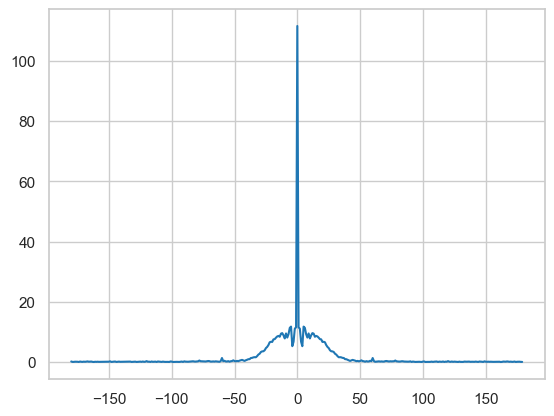

In [15]:
fft_hb = np.fft.fft(npzfile["heartbeats"][0])
fft_hb = np.fft.fftshift(fft_hb)
sns.lineplot(x=np.arange(-180, 180), y=np.abs(fft_hb))

<Axes: >

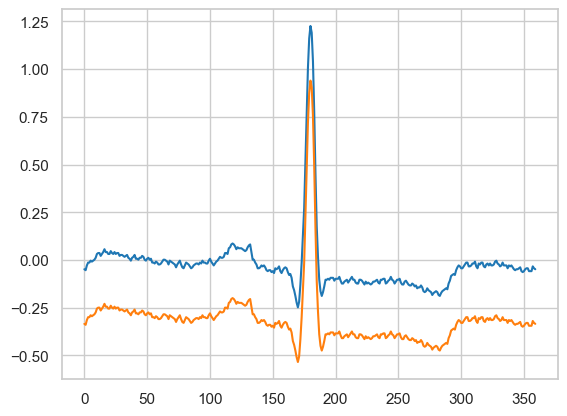

In [20]:
def one_hot_encode(label):
    possible_labels = ["N", "S", "V", "F", "Q"]
    # one hot encoding
    return torch.zeros(len(possible_labels)).scatter_(
        dim=0,
        index=torch.tensor(possible_labels.index(label)),
        value=1
    )

noise_frequencies = {
    "breathing": ([1/18, 1/12], [1/5, 1/3]) # breathing rate and impact
}

def noise_at_frequencies(hb, frequencies_distribution, fs=360):
    # hb: input heartbeat
    # frequencies_distribution: distribution of frequencies to add noise at
    # returns: hb with noise added at frequency
    
    # generate sinusoid noise with random phase and amplitude from the distribution
    noise = np.zeros(hb.shape)
    for (source, (freq_range, amp_range)) in frequencies_distribution.items():
        freq = np.random.uniform(freq_range[0], freq_range[1])
        amp = np.random.uniform(amp_range[0], amp_range[1])
        phase = np.random.uniform(0, 2 * np.pi)
        noise += amp * np.sin(2 * np.pi * freq * 1/fs + phase)
    return hb + noise

ax = sns.lineplot(x=np.arange(0, 360), y=noise_at_frequencies(npzfile["heartbeats"][0], noise_frequencies))
sns.lineplot(x=np.arange(0, 360), y=npzfile["heartbeats"][0], ax=ax)

In [31]:
def noise_at_frequencies_tensor(hb, frequencies_distribution, fs=360):
    # hb: input heartbeat
    # frequencies_distribution: distribution of frequencies to add noise at
    # returns: hb with noise added at frequency
    
    # generate sinusoid noise with random phase and amplitude from the distribution
    noise = torch.zeros(hb.shape)
    for (source, (freq_range, amp_range)) in frequencies_distribution.items():
        freq = torch.distributions.uniform.Uniform(freq_range[0], freq_range[1]).sample()
        amp = torch.distributions.uniform.Uniform(amp_range[0], amp_range[1]).sample()
        phase = torch.distributions.uniform.Uniform(0, 2 * torch.pi).sample()
        noise += amp * torch.sin(2 * torch.pi * freq * 1/fs + phase)
    return hb.add(noise)

def z_normalise(hb):
    return (hb - hb.mean()) / hb.std()

def hb_transform(hb):
    hb = torch.from_numpy(hb)
    hb = noise_at_frequencies_tensor(hb, noise_frequencies)
    hb = z_normalise(hb)
    return hb

In [32]:
train_set = ECGDataset("./data/heartbeats_train/", item_transform=hb_transform, target_transform=one_hot_encode)

In [36]:
train_set[0]

(tensor([-1.4884e-01, -1.7836e-01, -3.0752e-02,  5.7814e-02,  5.7814e-02,
          1.1686e-01,  8.7335e-02,  1.1686e-01,  1.4638e-01,  2.0542e-01,
          3.2351e-01,  3.5303e-01,  3.5303e-01,  2.6447e-01,  3.2351e-01,
          3.8255e-01,  4.7112e-01,  3.8255e-01,  3.8255e-01,  3.2351e-01,
          3.2351e-01,  4.1207e-01,  3.5303e-01,  3.2351e-01,  3.8255e-01,
          3.2351e-01,  3.5303e-01,  3.5303e-01,  2.6447e-01,  2.9399e-01,
          2.9399e-01,  2.6447e-01,  2.3494e-01,  2.6447e-01,  2.9399e-01,
          2.0542e-01,  1.7590e-01,  1.1686e-01,  2.0542e-01,  2.3494e-01,
          2.9399e-01,  1.7590e-01,  1.7590e-01,  1.4638e-01,  2.0542e-01,
          2.0542e-01,  2.6447e-01,  2.3494e-01,  1.4638e-01,  1.1686e-01,
          1.7590e-01,  2.0542e-01,  1.4638e-01,  1.7590e-01,  5.7814e-02,
          5.7814e-02,  2.8292e-02,  8.7335e-02,  5.7814e-02, -1.2301e-03,
         -1.2301e-03,  2.8292e-02,  8.7335e-02,  1.4638e-01,  1.4638e-01,
          1.1686e-01,  8.7335e-02, -1.